# Effect-site modeling for MPDP study

We want to estimate $C_e(t)$ at the midpoint of each CBF image frame, which in general will be at arbitrary points between the times when we drew blood. If we use piecewise linear interpolation to estimate $C_p(t)$ between blood samples (as did Unadkat *et al.*, 1986), there's a closed-form solution for $C_e$. Note, for $Cp(0)$ we can estimate $\beta$ from the time points after the end of the loading dose, and then estimate $Cp(0)=e^{\beta t_0}C_p(t_0)$ .

$C_e$ is defined by the rate equation $ C_e^{'} = k(C_p - C_e)$ (Unadkat *et al.*, 1986). Here $C_p$ is piecewise linear, say $C_{p}(t-t_i) = C_p(t_i) + m_i(t-t_i)$ on the interval $[t_i, t_{i+1}]$, where $m_i$ is defined as $m_i=\left(C_p(t_{i+1})-C_p(t_i)\right)/\left(t_{i+1}-t_i\right)$. We can also assume that $C_e(t_0)=C_p(t_0)$, since at the time of the first blood draw, the previous dose of levodopa was given 9+ hours ago, and the longest expected $t_{\frac{1}{2} e}$ is $<5$ hours, generally $<2.5$ hours (see Contin *et al.* 2001, Table 4).

From [wxMaxima](http://maxima.cesga.es/),

```
    eq1: 'diff(Ce(u), u) = k*(Cpi + m*u - Ce(u));
    atvalue(Ce(u), u=0, Ceu0);
    desolve(eq1, Ce(u));
```

substituting $u = t-t_i$ , Ceu0 = $C_e(t_i)$ , and Cpi = $C_p(t_i)$,

$$ C_{e}(t) = \left(C_p(t_i)-\frac{m_i}{k_e}\right) + m_i(t-t_i) + \left(C_e(t_i)-C_p(t_i)+\frac{m_i}{k_e}\right)e^{-k(t-t_i)} $$

defined on the interval $(t_i, t_{i+1}]$ .

In [1]:
import math
ln2 = math.log(2)
def ln2over(t):
    return ln2/t
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.integrate import ode

In [2]:
# Thanks to http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

## Read in a sample time-concentration curve and define a piecewise linear Cp(t) function

In [3]:
def correct_bloods(Cptimes, Cpsamples, insert_zero=True, zero_zero=False,
                   beta=0, insert_late_at=None, Cinf=600):
    """ Check blood sample times for sensible timing. Optionally add
        a sample at time zero if none was drawn. Optionally add a sample
        at time insert_late_at, after the last sample. 
        If beta > 0, correct inserted points for elimination.
    Cptimes: numpy array of times when blood was drawn
    Cpsamples: plasma concentrations at those times
    beta: terminal phase (elimination) rate constant = ln(2)/t1/2.
        Default beta = 0 (no elimination).
    insert_zero, insert_late_at: as above. If zero_zero, the 
        point added at t=0 is Cp(0)=0.0.
    Returns: new versions of Cptimes, Cpsamples
    """
    assert (Cptimes.size == Cpsamples.size), \
        "Sizes of Cptimes ({0}) and Cpsamples ({1}) arrays differ".format(Cptimes.size, Cpsamples.size)
    assert (np.all(Cptimes[1:] > Cptimes[:-1])), \
        "Cptimes not in strictly ascending order at index {0}".format(np.argmax(Cptimes[1:]<=Cptimes[:-1]))
    latest_neg = -1  # i.e. there is no t<0 so we can't correct for elimination
    no_t_0 = True
    for i in range(Cptimes.size):
        if Cptimes[i]<0: 
            if i>latest_neg:
                latest_neg = i
            if i==Cptimes.size-1 and insert_zero:
                # this is the last entry and t<0, so we have to append to the end
                Cptimes = np.append(Cptimes,0)
                Cpsamples = np.append(Cpsamples,Cpsamples[-1]*math.exp(beta*Cptimes[i]))
        elif Cptimes[i] == 0:
            no_t_0 = False
        else:  # Cptimes[i]>0
            if insert_zero:
                if i==1+latest_neg and latest_neg>-1:
                    # this is the first non-negative time after a negative time, and we want a Cp(0)
                    # make it smaller than the last level, based on decay
                    Cpsamples = np.insert(Cpsamples,i,Cpsamples[i-1]*math.exp(beta*Cptimes[i-1]))
                    Cptimes = np.insert(Cptimes,i,0)
    if insert_zero and Cptimes[0]>0:
        # we have no nonpositive times but still want a Cp(0)
        if zero_zero:
            Cpsamples = np.insert(Cpsamples,0,0.0)
        else:
            # make it larger than the first real level, based on backwards decay
            Cpsamples = np.insert(Cpsamples,0,Cpsamples[0]*math.exp(beta*Cptimes[0]))
        Cptimes = Cptimes = np.insert(Cptimes,0,0)

    if insert_late_at is not None:
        assert (insert_late_at >= Cptimes[-1]), \
            "{0} is not after {1}".format(insert_late_at, Cptimes[-1])
        if insert_late_at == Cptimes[-1]:
            pass  # don't duplicate last point (especially in case we already ran correct_bloods)
        else:
            Cpsamples = np.append(Cpsamples,
                Cpsamples[-1]+(Cpsamples[-1]-Cinf)*math.exp(-beta*(insert_late_at - Cptimes[-1])))
            Cptimes = np.append(Cptimes, insert_late_at)
    return Cptimes, Cpsamples

In [4]:
# Note, this example uses Cp(0) = Cp(t0)
Cptimes = np.asarray([-13.95, 5.33, 10.5, 12.53, 15.1, 19.25, 24.1, 30.1, 45.13, 60.13, 90.3, 128.48])
Cpsamples = np.asarray([0,902.81, 2780.19, 2965.27, 2015.83, 1489.56, 1232.83, 971.8, 833.71, 707.99, 631.24, 552.62])

In [5]:
Cptimes, Cpsamples = correct_bloods(Cptimes, Cpsamples)
print(Cptimes)
print(Cpsamples)
print()
Cptimes2, Cpsamples2 = correct_bloods(Cptimes, Cpsamples, beta=ln2over(90), 
                                      insert_late_at=150, Cinf=Cpsamples[-1])
print(Cptimes2)
print(Cpsamples2)

[-13.95   0.     5.33  10.5   12.53  15.1   19.25  24.1   30.1   45.13
  60.13  90.3  128.48]
[   0.      0.    902.81 2780.19 2965.27 2015.83 1489.56 1232.83  971.8
  833.71  707.99  631.24  552.62]

[-13.95   0.     5.33  10.5   12.53  15.1   19.25  24.1   30.1   45.13
  60.13  90.3  128.48 150.  ]
[   0.      0.    902.81 2780.19 2965.27 2015.83 1489.56 1232.83  971.8
  833.71  707.99  631.24  552.62  552.62]


In [6]:
def Cp(t, Cptimes, Cpsamples, beta=0, Cinf=0):  # numpy arrays
    """ Return a numpy array of estimated plasma levels at times t, based on
        known plasma concentrations Cpsamples at times Cptimes.
        WARNING: Assumes input has been cleaned with correct_bloods.
    t: numpy array of times
    Cptimes: times when blood was drawn
    Cpsamples: plasma concentrations at those times
    beta: terminal phase (elimination) rate constant = ln(2)/t1/2. Default 0 (constant).
    Cinf: for studies with constant infusion rate after some time, Cp(infinity)
    """
    tmin = Cptimes[ 0]-30
    assert (np.amin(t)>=tmin), "Cp(t) evaluated at t={0}".format(np.amin(t))
    tmax = Cptimes[-1]+30
    assert (np.amax(t)<=tmax), "Cp(t) evaluated at t={0}".format(np.amax(t))
    def m(i):  # scalar
        return (Cpsamples[i+1]-Cpsamples[i])/(Cptimes[i+1]-Cptimes[i])
    result = np.zeros_like(t)
    for i in range(Cptimes.size-1):
        mask = np.logical_and(t>=Cptimes[i],t<Cptimes[i+1])
        result[ mask ] = \
            Cpsamples[i] + m(i)*(t[mask]-Cptimes[i]) # for most values of t
    # for values outside the range sampled, estimate based on supplied elimination rate:
    result[t<Cptimes[ 0]] = Cpsamples[ 0]*np.exp(-beta*(t[t<Cptimes[ 0]]-Cptimes[ 0]))
    result[t>Cptimes[-1]] = Cinf + (Cpsamples[-1]-Cinf)*np.exp(-beta*(t[t>Cptimes[-1]]-Cptimes[-1]))
    return result

## Closed-form solution.

In [7]:
def Ce(t,k,Cptimes,Cpsamples,Ce0=None,extend=False,debug=False):
    """ Returns a numpy vector Ce(t), where
    t = numpy vector of times at which Ce is to be computed
    k = effect site rate constant (a.k.a. k_e or k_e0),
    based on blood levels Cpsamples at times Cptimes.
    If extend, assume constant Cp(t) after last point. [Not yet implemented.]
    Meant to be called once.
    """
    if k<0 or Cptimes.size==0 or Cpsamples.size==0:
        return np.full_like(t, np.nan, dtype=np.float_)
    if Ce0 == None:
        Ce0 = Cpsamples[0]
    working  = np.full_like(t, np.nan, dtype=np.float_) # will stay NaN at t values out of range
    for i in range(Cptimes.size-1):
        if i == 0:
            Ceti = Ce0  # "Ceti" means Ce(t_i)
            working[t==Cptimes[0]]=Ce0 # set Ce for any value of t == exactly the start time
        else:
            Ceti = temp
        def m(i):  # scalar
            return (Cpsamples[i+1]-Cpsamples[i])/(Cptimes[i+1]-Cptimes[i])
        xx = Cpsamples[i] - m(i)/k  # for convenience below
        # find elements with t in (t_i, t_{i+1}],
        indexi = np.logical_and(t>Cptimes[i], t<=Cptimes[i+1])
        # set those elements based on Ce(t_i)
        working[indexi] = xx + m(i)*(t[indexi]-Cptimes[i]) + \
            (Ceti-xx)*np.exp(-k*(t[indexi]-Cptimes[i]))
        # compute Ce(t_{i+1}) ("temp") and increment i:
        temp = xx + m(i)*(Cptimes[i+1]-Cptimes[i]) + (Ceti-xx)*math.exp(-k*(Cptimes[i+1]-Cptimes[i]))
        if debug:
            print('i={},\tt=({},{}],\tCeti={:.0f},\tCe(ti+1)={:.0f}'.format(
                i,Cptimes[i],Cptimes[i+1],Ceti,temp))
    return working

In [8]:
times = np.append(np.arange(-15,30),np.arange(30,150,5))
k_test = ln2over(28)
#check = Ce(times, k_test, times, Cp(times, Cptimes, Cpsamples, beta=ln2over(90), Cinf=600))
check = Ce(times, k_test, Cptimes, Cpsamples, Ce0=Cpsamples[0])

In [9]:
print(times[-8:])
print(check[-8:])

[110 115 120 125 130 135 140 145]
[683.15328553 671.77490049 660.52253333 649.38151274          nan
          nan          nan          nan]


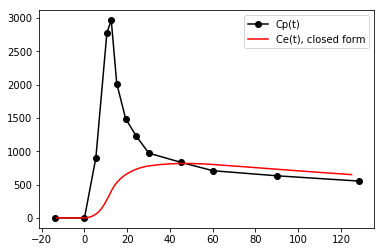

In [10]:
plt.plot(Cptimes, Cpsamples,'ko-',label='Cp(t)')
plt.plot(  times,     check,'r-', label='Ce(t), closed form')
plt.legend()
plt.show()
plt.close()

**Yay! It's working.**

## Test plots with different values of $k_e$

In [11]:
# PK-PD parameters for Park. Dz. patients' tapping speed response to levodopa after
# a 12-hour washout (see Contin et al 2001, Table 4)
stages = ['best','I','II','III','IV','worst'] 
thalfeqs = [277,133,78,28,20,5]
keqs = [ln2over(x) for x in thalfeqs]
ec50s = [100,200,290,600,940,1200]
hillns = [1,2,5,7,18,49]

In [12]:
times = np.append(np.arange(-10,30),np.arange(30,151,5))
cmap = get_cmap('viridis')
#print('\n'.join(map(str,[cmap(0),cmap(128),cmap(255),cmap(257),cmap(500)])))
colors = list(map(cmap,range(0,1+255,int(255/(len(stages)-1)))))
#colors.reverse()
lines = ['dashed','solid','dashed','solid','dashed','solid']

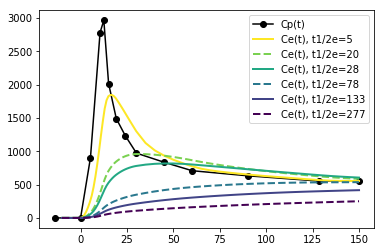

In [13]:
Cptimes2, Cpsamples2 = correct_bloods(Cptimes, Cpsamples, beta=ln2over(90), 
                                      insert_late_at=150, Cinf=Cpsamples[-1])
plt.plot(Cptimes2, Cpsamples2,'ko-',label='Cp(t)')
#plt.plot(times, thiscp, 'o-', color='aqua')
for i in reversed(range(len(stages))):
    ces = Ce(times, keqs[i], Cptimes2, Cpsamples2)
    plt.plot(times, ces, color=colors[i], linestyle=lines[i],
             linewidth = 2.0,
             label='Ce(t), t1/2e={0}'.format(thalfeqs[i]))
plt.legend()
plt.show()
plt.close()

## OK. Now effect curves.

In [14]:
def effect(ce, ec50, n):
    """E(Ce(t)), drug effect at time t, based on [LD] in effect compartment, using a sigmoid PD model.
    ce is a numpy array of effect-site [LD] concentrations.
    ec50 is the EC50 (concentration at which effect is 50%*Emax)
    n is the Hill constant.
    Units: Ce(t) and EC50 ng/ml, n dimensionless.
    Assumes that E(0) = 0 and Emax = 1 = 100%.
    """
    return ce**n/(ce**n + ec50**n)

t1/2alpha = 5.0, ec50 = 1200, n = 49, Ce(20.0) = [1753.27561938], effect(20.0) = [0.9999999914646455]
t1/2alpha = 20.0, ec50 = 940, n = 18, Ce(20.0) = [862.79495623], effect(20.0) = [0.1761502976781649]
t1/2alpha = 28.0, ec50 = 600, n = 7, Ce(20.0) = [663.76248582], effect(20.0) = [0.6697297684121247]
t1/2alpha = 78.0, ec50 = 290, n = 5, Ce(20.0) = [269.37509541], effect(20.0) = [0.40881155]
t1/2alpha = 133.0, ec50 = 200, n = 2, Ce(20.0) = [162.64010871], effect(20.0) = [0.39805999]
t1/2alpha = 277.0, ec50 = 100, n = 1, Ce(20.0) = [79.7955953], effect(20.0) = [0.44381285]


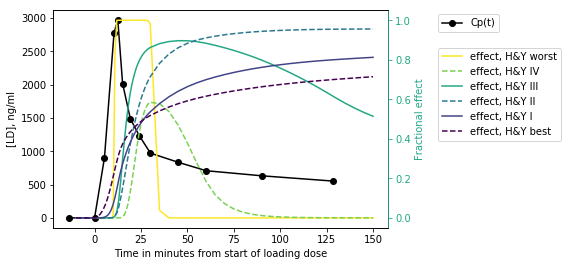

In [15]:
debug = False
debug3 = True

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time in minutes from start of loading dose')
ax1.set_ylabel('[LD], ng/ml')
ax1.plot(Cptimes, Cpsamples,'ko-',label='Cp(t)')
ax1.legend(loc=(1.15,0.9))

ax2 = ax1.twinx()  # instantiate a second "axes" that shares the same x-axis
ax2.set_ylabel('Fractional effect')
for i in reversed(range(len(stages))):
#for i in (range(len(stages))):
#for i in [2]:
    ces = Ce(times, keqs[i], Cptimes2, Cpsamples2)
    effects = effect(ces,ec50s[i],hillns[i])
    peakwhere = np.abs(times-20.0)<0.5
    if debug3:
        print('t1/2alpha = {}, ec50 = {}, n = {}, Ce(20.0) = {}, effect(20.0) = {}'.format(
            ln2over(keqs[i]),ec50s[i],hillns[i], ces[peakwhere], effects[peakwhere]))
    #plt.axis((0,120,0,3500))
    ax2.plot(times, effects, color=colors[i], linestyle=lines[i],
             label='effect, H&Y {}'.format(stages[i]))
    #ax2.plot(times, 1/(1+ (ec50s[i]/ces)**hillns[i]), 'r-')
    #ax2.plot(times, (ces**hillns[i])/((ces**hillns[i])+ ec50s[i]**hillns[i]), 'b-')
ax2.legend(loc=(1.15,0.4))
ax2.yaxis.label.set_color(colors[3])
ax2.tick_params(axis='y',colors=colors[3])
ax2.spines['right'].set_color(colors[3])
plt.show()
fig.savefig('test.png', dpi=600, transparent=True, bbox_inches="tight")
plt.close()

## OK. We want to cover the likely range of $C_p(t)$ curves we will see in our volunteers.

I'll take high, low and medium blood curves from the "final method" of [Black et al. 2003](https://www.ncbi.nlm.nih.gov/pubmed/12865145). Here are the original data:

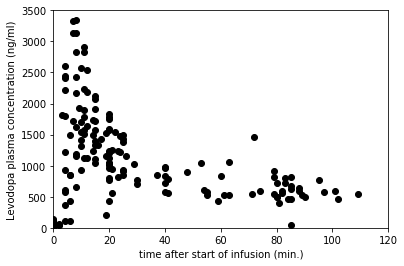

In [16]:
import csv
with open('Cp_estimation_20150304.csv', 'rb') as datafile:
    data  = np.genfromtxt(datafile, delimiter=",", usecols=range(0,7), names=True)  # imports as floats
    # the file has 7 blank rows at the end ...
    data = data[:-7]
data_times=data['new_minutes']
data_concs=data['LD']

%matplotlib inline
plt.scatter(data_times,data_concs,color='black')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)')  # ,fontsize=16
plt.ylabel('Levodopa plasma concentration (ng/ml)')
plt.show()
plt.close()

In [17]:
glob_interval_end = np.asarray([2.5, 6.5, 12.5, 17.5, 27.5, 35, 45, 70, 90, 120])
# create a list of arrays with points selected from data, with one array for each interval\n",
num_globs = glob_interval_end.size
globtime  = []
globconc  = []
globsize  = np.zeros([num_globs],int)
globmeant = np.zeros([num_globs])
globmeanc = np.zeros([num_globs])
globsdt = np.zeros([num_globs])
globsdc = np.zeros([num_globs])

DEBUG = True
start = -.001
for i in range(num_globs):
    end = glob_interval_end[i]
    items = np.logical_and(data_times > start,data_times <=end)
    globtime.append(data_times[np.nonzero(items)])  # this array is now globtime[i]
    globconc.append(data_concs[np.nonzero(items)])
    globsize[i]  = globtime[i].size
    globmeant[i] = np.mean(globtime[i])
    globmeanc[i] = np.mean(globconc[i])
    globsdt[i] = np.std(globtime[i])
    globsdc[i] = np.std(globconc[i])
    # The true peak Cp has to be at or after the end of the loading dose, 10 min., so one more tweak. 
    # Let's extrapolate to a peak at 10 minutes. The first 3 points are nearly collinear (R=0.998), and 
    # the best fit line through them includes (10,2532.92). But, sigh, 2238 was already the 
    # best choice peak. Oh well, arbitrary but reasonable choice here.
    if i==2:
        globsize[i] = 14
        globmeant[i] = 10 # was (9, 2237.9)
        globmeanc[i] = 2532.92 # was (9, 2237.9)
        globsdt[i] = 1 # was 1.66
        globsdc[i] = 794.3
        if DEBUG:
            print('interval i={0}, start time = {1}, end time = {2}, globsize[{0}]={3}'.\
                  format(i,start,end,globsize[i]))
            # print(items)
            print(globtime[i])
            print(globconc[i])
            print('  actual mean time in this interval: {0:.2f} +- {1:.2f}; mean conc in this interval: {2:.2f} +- {3:.2f}'.\
                  format(np.mean(globtime[i]),np.std(globtime[i]), np.mean(globconc[i]), np.std(globconc[i])))
            print('reported mean time in this interval: {0:.2f} +- {1:.2f}; mean conc in this interval: {2:.2f} +- {3:.2f}'.\
                  format(globmeant[i], globsdt[i], globmeanc[i], globsdc[i]))
    start = end

interval i=2, start time = 6.5, end time = 12.5, globsize[2]=14
[ 8.  7. 11.  8.  8. 11.  8. 11.  8. 12.  8. 11.  7.  9. 10. 11.  8. 12.
  7. 10.  8. 10. 11. 12.  8. 10. 11. 12. 10. 11. 10.]
[2165. 3130. 2911. 1185. 2420. 2236. 3141. 2823. 2830. 2186. 1627. 1784.
 1722. 1924. 1698. 1575. 3348. 2536. 3331. 2565. 1153. 1320. 1891. 1643.
  664.  930. 1118. 1131. 1409. 1510. 1541.]
  actual mean time in this interval: 9.61 +- 1.64; mean conc in this interval: 1982.16 +- 741.43
reported mean time in this interval: 10.00 +- 1.00; mean conc in this interval: 2532.92 +- 794.30


time:      0.4,    4.5,   10.0,   15.0,   21.6,   29.7,   39.9,   57.1,   82.0,  100.8
[LD]:     54.8, 1226.7, 2532.9, 1538.4, 1157.7,  828.7,  779.6,  702.1,  624.2,  589.8
S.D.:     40.3,  824.7,  794.3,  324.5,  377.6,  138.1,  146.2,  219.9,  244.5,  101.7
N   :       17,     17,     14,     14,     33,      3,      8,     10,     24,      5


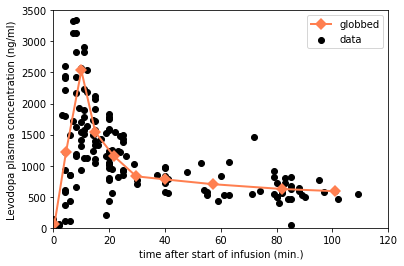

In [18]:
# Re-plot the real observed data with the Newer, Improved-er "globbed" data:
plt.scatter(data_times,data_concs,color='black',label='data')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
plt.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='globbed') 
    # marker=(8,2,0),marker='D',marker='o',markeredgecolor='lime',
    # http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

plt.legend(loc='upper right')
printstringend = (num_globs-1)*'{:7.1f},'+'{:7.1f}'
print('time:  '+printstringend.format(*globmeant))
print('[LD]:  '+printstringend.format(*globmeanc))
print('S.D.:  '+printstringend.format(*globsdc))
printstringend = (num_globs-1)*'{:7d},'+'{:7d}'
print('N   :  '+printstringend.format(*globsize))
plt.show()

That's the medium $C_p(t)$. Now for a low and high $C_p(t)$. 

In [19]:
globclo = np.zeros([num_globs])
globchi = np.zeros([num_globs])
for i in range(num_globs):
    globclo[i] = np.amin(globconc[i])
    globchi[i] = np.amax(globconc[i])

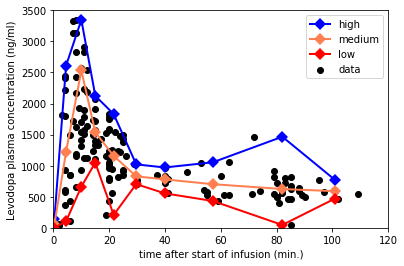

In [20]:
plt.scatter(data_times,data_concs,color='black',label='data')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
plt.plot(globmeant,globchi,'blue',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='high') 
plt.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='medium') 
plt.plot(globmeant,globclo,'red',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='low') 
plt.legend(loc='upper right')
plt.show()

The "low" values just look silly. Try one more time with a slight modification: use the 5<sup>th</sup> or 10<sup>th</sup> percentile at each time point rather than the minimum. May as well try the same for the "high" values.

In [21]:
for i in range(num_globs):
    globclo[i] = np.percentile(globconc[i],10)
    globchi[i] = np.percentile(globconc[i],90)

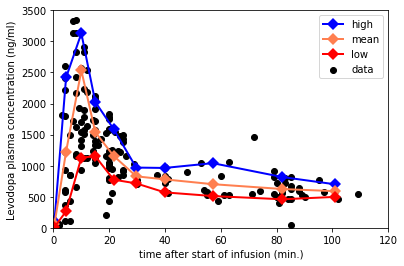

In [22]:
fig, ax1 = plt.subplots()
ax1.scatter(data_times,data_concs,color='black',label='data')
ax1.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
ax1.plot(globmeant,globchi,'blue',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='high') 
ax1.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='mean') 
ax1.plot(globmeant,globclo,'red',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='low') 
ax1.legend(loc='upper right')
plt.show()
fig.savefig('Cp-hi-mean-lo.png', dpi=600, transparent=True)
plt.close()

In [23]:
with printoptions(precision=2,formatter={'float_kind':'{:.1f}'.format}):
    print('mean times:\n', globmeant)
with printoptions(precision=2,formatter={'float_kind':'{:.0f}'.format}):
    print('high:\n', globchi)
    print('mean:\n', globmeanc)
    print('low:\n', globclo)

mean times:
 [0.4 4.5 10.0 15.0 21.6 29.7 39.9 57.1 82.0 100.8]
high:
 [105 2420 3130 2025 1589 969 963 1040 817 701]
mean:
 [55 1227 2533 1538 1158 829 780 702 624 590]
low:
 [11 266 1131 1150 775 715 570 511 459 497]


That's more like it. All right. Ready to go.

First repeat the time:concentration curves in the effect compartment for different disease severity levels:

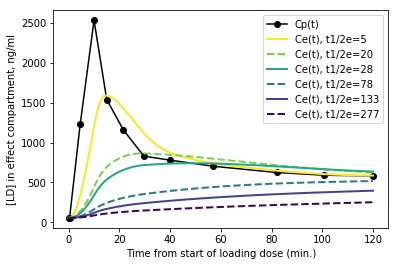

In [24]:
times = np.append(np.arange(0,30),np.arange(30,121,5))
Cptimes, Cpsamples = correct_bloods(
    globmeant, globmeanc, insert_zero=True, beta=ln2over(90), insert_late_at=times[-1])

fig, ax1 = plt.subplots()
plt.plot(Cptimes, Cpsamples,'ko-',label='Cp(t)')
ax1.set_xlabel('Time from start of loading dose (min.)')
ax1.set_ylabel('[LD] in effect compartment, ng/ml')
for i in reversed(range(len(stages))):
    ces = Ce(times, keqs[i], Cptimes, Cpsamples)
    plt.plot(times, ces, color=colors[i], linestyle=lines[i],
             linewidth = 2.0,
             label='Ce(t), t1/2e={0}'.format(thalfeqs[i]))
plt.legend()
plt.show()
fig.savefig('time-conc-effect-compart.png', dpi=600, transparent=True)
plt.close()

Now for the time:effect curves:

In [25]:
times = np.append(np.arange(0,30),np.arange(30,121,5))

def graph_effects(graphconc, graphtime=globmeant, Cinf=None, subtitle=None, savefig=False):
    """
    graphconc is meant to be globchi, globmeanc, or globclo
    graphtime is meant to be globmeant
    """
    if Cinf == None:
        Cinf=graphconc[-1]
    Cptimes, Cpsamples = correct_bloods(
        graphtime, graphconc, insert_zero=True, zero_zero=True,
        beta=ln2over(90), insert_late_at=times[-1], Cinf=Cinf)
    if Cptimes[0]>0.0:
        Cptimes = np.insert(Cptimes,0,0.0)
        Cpsamples = np.insert(Cpsamples,0,0.0)
    
    fig, ax1 = plt.subplots()
    plt.title('Predicted effect: '+subtitle+' Cp(t)')
    ax1.set_xlabel('Time from start of loading dose (min.)')
    ax1.set_ylabel('[LD], ng/ml')
    ax1.set_ylim(0,3500)
    ax1.plot(graphtime, graphconc,'ko-',label='Cp(t)')
    #ax1.plot(Cptimes,   Cpsamples,'kx')
    ax1.legend(loc=(1.15,0.9))

    ax2 = ax1.twinx()  # instantiate a second "axes" that shares the same x-axis
    ax2.set_ylim(0,1.01)
    ax2.set_ylabel('Fractional effect')
    for i in reversed(range(len(stages))):
        ces = Ce(times, keqs[i], Cptimes, Cpsamples)
        effects = effect(ces,ec50s[i],hillns[i])
        peakwhere = np.abs(times-20.0)<0.5
        ax2.plot(times, effects, color=colors[i], linestyle=lines[i],
                 linewidth=2.0, label='effect, H&Y {}'.format(stages[i]))
    ax2.legend(loc=(1.15,0.4))
    ax2.yaxis.label.set_color(colors[3])
    ax2.tick_params(axis='y',colors=colors[3])
    ax2.spines['right'].set_color(colors[3])
    plt.show()
    temp = subtitle+'.png'
    if savefig:
        fig.savefig(temp, dpi=600, transparent=True, bbox_inches="tight")
    plt.close()

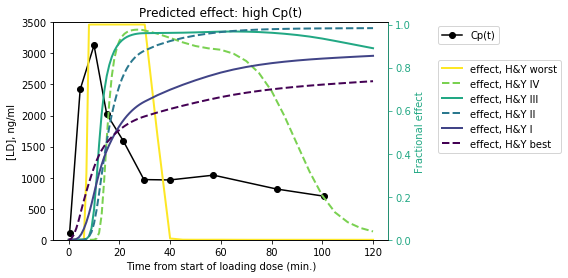

In [26]:
graph_effects(globchi, subtitle='high', savefig=True)

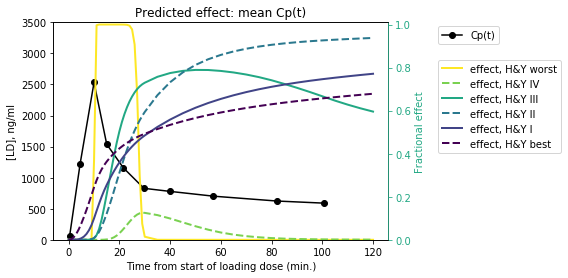

In [27]:
graph_effects(globmeanc, subtitle='mean', savefig=True)

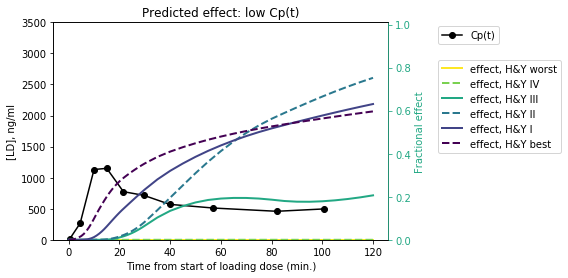

In [28]:
graph_effects(globclo, Cinf=globclo[-2], subtitle='low')

That's a little ugly. Maybe approximate it with a better-looking curve?

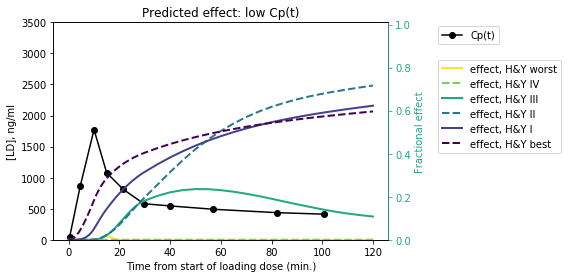

In [29]:
nicelow = globmeanc*.7
graph_effects(nicelow, subtitle='low', savefig=True)

This time:concentration curve produces about the same time:effect curves, so that's good.

But that's too little levodopa, especially for more affected participants. 

### Let's try a higher infusion rate ... 

... for both loading and maintenance phases, and assuming linear kinetics.

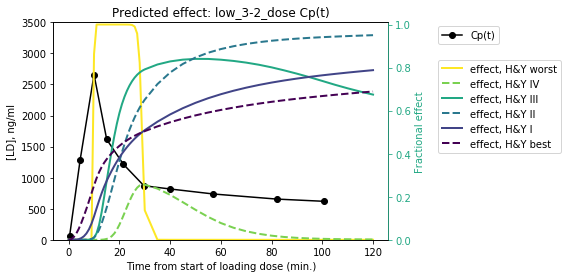

In [30]:
graph_effects(nicelow*3/2, subtitle='low_3-2_dose', savefig=True)

What would that do to the slower-metabolizing folks?

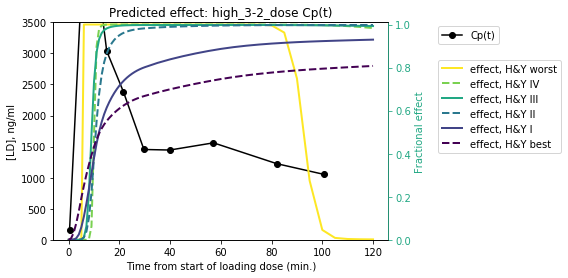

In [31]:
graph_effects(globchi*3/2, subtitle='high_3-2_dose', savefig=True)

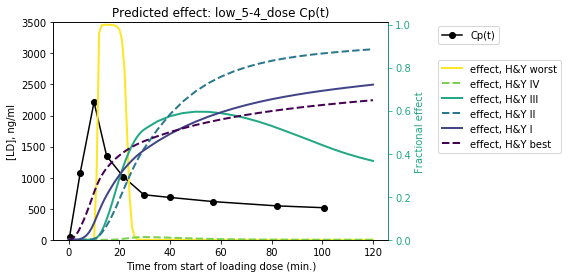

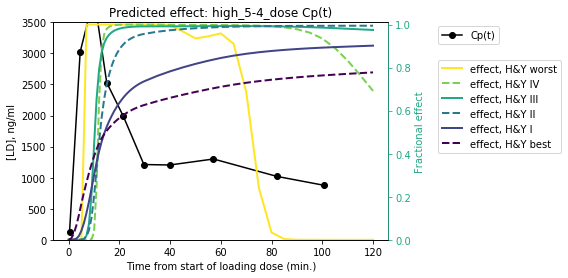

In [32]:
graph_effects(nicelow*5/4, subtitle='low_5-4_dose', savefig=True)
graph_effects(globchi*5/4, subtitle='high_5-4_dose', savefig=True)

Ouch. So maybe we need to use a higher dose, but only for the more severely affected participants. But really, what we want is to know in advance what the pharmacokinetics are in each subject. That's possible, with a minimum of say, one i.v. bolus and a blood level just before and at a single time point after the bolus. That could be done on the screening day, but it would complicate the design. Ah well, it's important but an implementation detail.

## Resample effect curves to fit plausible ASL timepoints

Approximate the mean value within the (relatively short) CBF acquisition time by the midpoint value.

In [33]:
# Times for ASL frame start, end & midpoint, in minutes, for a ~9'40\" pCASL series
# (See Google sheet MPDP_ASL_timing for more details)

frame1start = 7/60. # first frame starts about 7 sec. after hitting start
TR = 17/60.  # 17sec., in min. (one GRASE frame--effective TR for an ASL frame is twice that)
numframes = 18  # meaning ASL frames, so twice as many GRASE frames (but really there 
    # are 1 fewer ASL frames since the first 2 GRASE frames don't produce an ASL image)
# "range(1," in the next line because the first 2 GRASE frames don't produce an ASL image
aslstarts = np.fromiter((frame1start + 2*i*TR for i in range(1, numframes)), np.float) 
aslendpts = aslstarts + 2*TR
aslmidpts = (aslstarts + aslendpts)/2
# Note: aslendpts[-1] = 10.32 min. So let's say it's 11'00\" between series, start to start.
# On average that's probably about what it will be.
# So for frame i, counting from 0, frames will start at 11*i + aslstarts.
seriesduration = 11 # minutes
# Times for ASL frame starts, in minutes, from the beginning to the end of the scan:
duration = 125 # minutes
numruns = duration // seriesduration
asl_start_all = np.concatenate([seriesduration*run + aslstarts for run in range(numruns)])
baselinestart = -12.0  # minutes before drug infusion begins
# add one baseline, pre-drug scan starting baselinestart min. before drug infusion begins
asl_start_all = np.insert(asl_start_all, 0, baselinestart + aslstarts)
asl_endpt_all = asl_start_all + 2*TR
asl_midpt_all = (asl_start_all + asl_endpt_all)/2
print('number of frames (time points) in asl_midpt_all: ', len(asl_midpt_all))
print(asl_midpt_all[:4], '...', asl_midpt_all[-4:])

number of frames (time points) in asl_midpt_all:  204
[-11.03333333 -10.46666667  -9.9         -9.33333333] ... [118.33333333 118.9        119.46666667 120.03333333]


In [34]:
aslstarts

array([0.68333333, 1.25      , 1.81666667, 2.38333333, 2.95      ,
       3.51666667, 4.08333333, 4.65      , 5.21666667, 5.78333333,
       6.35      , 6.91666667, 7.48333333, 8.05      , 8.61666667,
       9.18333333, 9.75      ])

In [35]:
debug = False
if debug:
    print(  'asl_start_all:\n', asl_start_all[:20], '...\n', asl_start_all[-20:])
    print('\nasl_midpt_all:\n', asl_midpt_all[:20], '...\n', asl_midpt_all[-20:])
    print('\nasl_endpt_all:\n', asl_endpt_all[:20], '...\n', asl_endpt_all[-20:])

In [36]:
# Using 50 ml/hg/min for resting rCBF, and 10 ml/hg/min rCBF response to LD in midbrain
meansize   = 50  # ml/hg/min
effectsize = 10  # ml/hg/min

In [37]:
globmeant

array([  0.35294118,   4.52941176,  10.        ,  15.        ,
        21.57575758,  29.66666667,  39.875     ,  57.1       ,
        82.04166667, 100.8       ])

In [38]:
globmeanc

array([  54.76470588, 1226.70588235, 2532.92      , 1538.42857143,
       1157.6969697 ,  828.66666667,  779.625     ,  702.1       ,
        624.20833333,  589.8       ])

In [39]:
# for each Cp(t), add a value of Cp(t) based on (un-)decay at the start of 
#   the baseline scan and at time = 0
# These are now cphi, cpmean and cplow:
original_cps = [globchi, globmeanc, nicelow]
cps = [[],[],[]]
beta=ln2over(90)
for i in range(len(original_cps)):
    # add a time point at zero and at 120
    # def correct_bloods(Cptimes, Cpsamples, insert_zero=True, beta=0, insert_late_at=None, Cinf=600):
    cpt, cp =  correct_bloods(globmeant, original_cps[i], beta=beta,
                             insert_late_at=120, Cinf=original_cps[i][-1])
    # add a blood level at that time point based on (un-)decay prior to zero
    cps[i] = np.insert(cp, 0, cp[0]*math.exp(-beta*baselinestart))
# add a time point at baselinestart:
cpt = np.insert(cpt, 0, baselinestart)


In [40]:
print(cpt)
for x in cps:
    print(x)

[-12.           0.           0.35294118   4.52941176  10.
  15.          21.57575758  29.66666667  39.875       57.1
  82.04166667 100.8        120.        ]
[ 115.92002161  105.68689057  105.4        2419.6        3130.
 2025.         1589.          969.2         963.3        1040.5
  816.9         701.          701.        ]
[  60.23079591   54.91377114   54.76470588 1226.70588235 2532.92
 1538.42857143 1157.6969697   828.66666667  779.625       702.1
  624.20833333  589.8         589.8       ]
[  42.16155714   38.4396398    38.33529412  858.69411765 1773.044
 1076.9         810.38787879  580.06666667  545.7375      491.47
  436.94583333  412.86        412.86      ]


In [41]:
times = np.append(np.arange(-12,30),np.arange(30,121,5))
replicates = 100

savefiles = False
# Save as 4-byte float for compatibility with "4dfp" image file format.
midpteffects = np.zeros((len(stages),len(cps),replicates,len(asl_midpt_all)),
                        dtype=np.float32)
for i in range(len(stages)):  # for each H&Y stage:
    for j in range(len(cps)):  # for each Cp curve j (i.e., for each voxel in first frame):
        ces = Ce(asl_midpt_all, keqs[i], cpt, cps[j]) 
        # NOTE: The corresponding time points are asl_midpt_all.
        for k in range(replicates):
            midpteffects[i,j,k,:] = meansize + \
                effectsize * effect(ces,ec50s[i],hillns[i]) # .astype(np.float32)
    if savefiles:
        with open('effect_'+stages[i]+'.4dfp.img', 'wb') as effectfile:
            # swap axes because .4dfp.img format is concat(frame0, frame1, ...)"
            np.swapaxes(midpteffects[i],0,-1).tofile(effectfile)  

In [42]:
midpteffects.shape

(6, 3, 100, 204)

In [43]:
print(i, j, k)
temp = np.swapaxes(midpteffects[2],0,-1)
temp[:,:3,:]

5 2 99


array([[[50.101   , 50.003864, 50.00065 ],
        [50.101   , 50.003864, 50.00065 ],
        [50.101   , 50.003864, 50.00065 ]],

       [[50.10098 , 50.00386 , 50.00065 ],
        [50.10098 , 50.00386 , 50.00065 ],
        [50.10098 , 50.00386 , 50.00065 ]],

       [[50.100945, 50.00386 , 50.00065 ],
        [50.100945, 50.00386 , 50.00065 ],
        [50.100945, 50.00386 , 50.00065 ]],

       ...,

       [[59.87418 , 59.48182 , 57.546253],
        [59.87418 , 59.48182 , 57.546253],
        [59.87418 , 59.48182 , 57.546253]],

       [[59.874214, 59.48351 , 57.552628],
        [59.874214, 59.48351 , 57.552628],
        [59.874214, 59.48351 , 57.552628]],

       [[      nan,       nan,       nan],
        [      nan,       nan,       nan],
        [      nan,       nan,       nan]]], dtype=float32)

In [44]:
debug4 = True
if debug4:
    print(midpteffects.shape)
    print((midpteffects[0,0,:]).shape)
    thiscp = Cp(times, cpt, cps[1], beta=ln2over(90), Cinf=cps[1][-1])
    ces = Ce(asl_midpt_all, keqs[1], times, thiscp) 
    print(ces.shape)
    print(times.shape)
    print(len(cps))

(6, 3, 100, 204)
(100, 204)
(204,)
(61,)
3


### Check work for mean Cp(t):

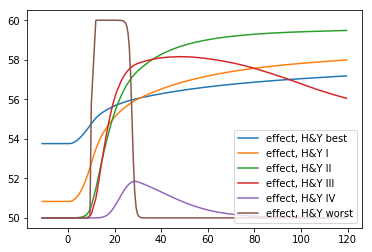

In [45]:
for i in range(len(stages)):
    plt.plot(asl_midpt_all, midpteffects[i,1,0,:],label='effect, H&Y {}'.format(stages[i]))
plt.legend(loc='lower right')
plt.show()
plt.close()

## Add noise to effect data

In [46]:
# 24% was mean CoV over 3 subjects for movement-smoothed CBF in a cortical region
# from pCASL data (see baseline_signal_CBF_interpolated.xlsx for details)
mySD = 0.24 * effectsize
SDs     = [mySD]  # originally had considered repeating for various SDs
# approximately a fixed ration of 10^(-1/3), which would be equidistant on a log scale
SDnames = ['24pct']

savefiles = False

# The shape of the array is irrelevant--it could be flattened and work the same--but 
# writing it this way may help clarify the intent, i.e. to be added to the effect arrays 
noise = np.zeros((len(SDs), len(cps), replicates, len(asl_midpt_all)),dtype=np.float32) 
# 4-byte data (np.float32), for use with lab .4dfp format
for m in range(len(SDs)):
    noise[m] = np.random.normal(0.0, SDs[m], size=(len(cps), replicates, len(asl_midpt_all)) )
print('noise.shape =',noise.shape)
with printoptions(precision=2,formatter={'float_kind': '{:.2f}'.format}):
    print('means:  (goal = 0.0)')
    print('{:.2f}'.format(np.mean(noise)))
    print('S.D.s:  (goal = {:.1f})'.format(SDs[m]))
    print('{:.2f}'.format(np.std(noise)))
    print('first 3 elements for each SD:')
    print(noise[:,0,0,:3])

if savefiles:
    for m in range(len(SDs)):
        with open('noise_'+SDnames[m]+'.4dfp.img', 'wb') as f:
            noise[m].tofile(f)


noise.shape = (1, 3, 100, 204)
means:  (goal = 0.0)
-0.02
S.D.s:  (goal = 2.4)
2.39
first 3 elements for each SD:
[[4.03 -0.27 -1.43]]


In [47]:
import matplotlib
print (matplotlib.__version__)

2.2.3
